In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from deap import base, creator, tools
from deap.benchmarks import ackley

In [ ]:
# Create Fitness class (for minimization)
# createは"class factory"で、新しいクラスを継承して動的に作成するために使う
# FitnessMinという名前で、base.Fitnessを継承し、weights=(-1.0,)で最小化問題を定義する
# 最大化する場合はweights=(1.0,), タプルに複数指定すると多目的最適化になる
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# Create Individual class
# listを継承し、fitness属性にFitnessMinを持つIndividualクラスを作成
creator.create("Individual", list, fitness=creator.FitnessMin)

# Create Toolbox
toolbox = base.Toolbox()

############## set toolbox
# Register "attr_gene" to generate genes (a float between -500 and 500)
toolbox.register("attr_gene", random.uniform, -500, 500)

# Register "individual" to generate individuals, composed of 2 genes
# 個体を1つ生成する関数を登録
# 2は個体の遺伝子数で、(x, y)の2次元ベクトル
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_gene, 2)

# Register "population" to generate a population of individuals
# 個体を沢山生成する関数を登録, Individual関数を繰り返し呼び出してリストを作成, 繰り返し数は後で指定
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register "evaluate" for the evaluation function (Ackley function)
toolbox.register("evaluate", ackley)

# Register "mate" for crossover (Blend Crossover)
# BLX-α crossover, alpha=0.2
toolbox.register("mate", tools.cxBlend, alpha=0.2)
# cxSimulatedBinaryBounded
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=[-500, -500], up=[500, 500], eta=20.0)

# Register "mutate" for mutation (Gaussian Mutation)
# gaussian mutation with mu=0.0, sigma=200.0, and indpb=0.2 for two genes
toolbox.register("mutate", tools.mutGaussian, mu=[
                 0.0, 0.0], sigma=[200.0, 200.0], indpb=0.2)
# mutPolynomialBounded
toolbox.register("mutate", tools.mutPolynomialBounded, low=[-500, -500], up=[500, 500], eta=20.0, indpb=0.2)

# Register "select" for the selection method
# トーナメント選択, tournsize=、残りの対象個体数、選択個体数は後で指定
toolbox.register("select", tools.selTournament, tournsize=3)
# roulette selection, probability proportional to fitness
toolbox.register("select", tools.selRoulette)

############## set toolbox

In [3]:
# Set a random seed for reproducibility
random.seed(42)

# GA parameters
POP_SIZE = 1000
CX_PB = 0.5  # Crossover probability
MUT_PB = 0.2 # Mutation probability
N_GEN = 100

In [4]:
# Generate initial population by using 個体群を生成する関数
pop = toolbox.population(n=POP_SIZE)

# Create Hall of Fame to store the best individual <-- 最終世代以外の途中のベストも保存するオブジェクト
hof = tools.HallOfFame(1)

# 統計情報とログの設定
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

logbook = tools.Logbook()
logbook.header = "gen", "nevals", "min", "avg", "std"


# 1. 最初の世代の適応度を評価
# Evaluate the fitness of the entire population
invalid_ind = [ind for ind in pop if not ind.fitness.valid]
#fitnesses = list(map(toolbox.evaluate, invalid_ind))
fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)

# Assign fitness values (output of the ackley) to individuals
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit

In [30]:
# LogbookとHallOfFameを最初の世代で更新
hof.update(pop)
record = stats.compile(pop)
logbook.record(gen=0, nevals=len(invalid_ind), **record)
print(logbook.stream) # 最初の世代の統計情報を表示

gen	nevals	min    	avg    	std     
0  	1000  	19.2911	21.6028	0.558073


In [31]:
# Start evolution loop
for gen in tqdm(range(1, N_GEN + 1)):

    # Select and clone the next generation individuals
    offspring = toolbox.select(pop, len(pop)) # tournament selection
    offspring = list(map(toolbox.clone, offspring)) # clone individuals to avoid modifying the original ones

    # Apply crossover
    for child1, child2 in zip(offspring[::2], offspring[1::2]): # 隣合う個体をペアにする
        # Select individuals for crossover
        if random.random() < CX_PB:
            toolbox.mate(child1, child2)
            # Delete the fitness value of children after crossover
            del child1.fitness.values
            del child2.fitness.values

    # Apply mutation
    for mutant in offspring:
        # Select individual for mutation
        if random.random() < MUT_PB:
            toolbox.mutate(mutant)
            # Delete the fitness value of the mutant
            del mutant.fitness.values

    # Re-evaluate the fitness of individuals with invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid] # pick individuals with invalid fitness
    fitnesses = map(toolbox.evaluate, invalid_ind) # 上と同じ計算
    for ind, fit in zip(invalid_ind, fitnesses): # 上と同じ計算
        ind.fitness.values = fit

    # Update the population with the new generation #　子世代を親世代に置き換え
    pop[:] = offspring

    # LogbookとHallOfFameを更新
    hof.update(pop)
    record = stats.compile(pop)
    logbook.record(gen=gen, nevals=len(invalid_ind), **record)
    #print(logbook.stream)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:02<00:00, 36.26it/s]



-- End of (successful) evolution --
individual: [-6.383406161823036e-17, -1.213868873658014e-16]
fitness: 0.0


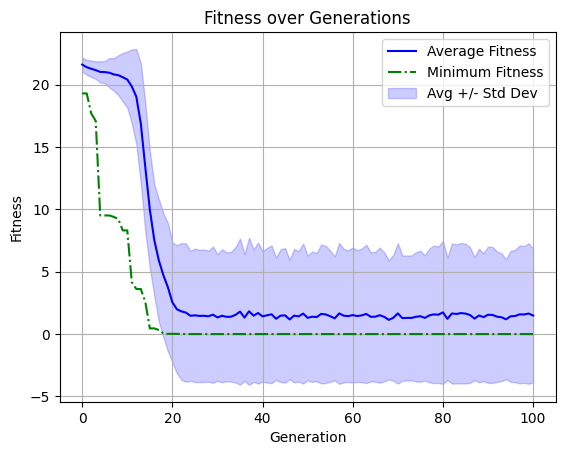

In [32]:
# show final results
print("\n-- End of (successful) evolution --")
print(f"individual: {hof[0]}")
print(f"fitness: {hof[0].fitness.values[0]}")

# --- graph ---
gen = logbook.select("gen")
avg = logbook.select("avg")
std = logbook.select("std")
min_ = logbook.select("min")
fig, ax1 = plt.subplots()

# mean with solid line
line1 = ax1.plot(gen, avg, "b-", label="Average Fitness")

# min with dashed line
line2 = ax1.plot(gen, min_, "g-.", label="Minimum Fitness")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")

# std deviation as shaded area
std_upper = np.array(avg) + np.array(std)
std_lower = np.array(avg) - np.array(std)
ax1.fill_between(gen, std_lower, std_upper, color='b', alpha=0.2, label="Avg +/- Std Dev")

ax1.legend(loc="upper right")
plt.title("Fitness over Generations")
plt.grid(True)
plt.show()